# Feature Generation

In [50]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow import keras
from keras.losses import kullback_leibler_divergence
from keras.regularizers import Regularizer
from keras.models import Sequential
from keras.layers import Flatten, Dense, Reshape, Input
from tensorflow.keras.models import Model
from keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.regularizers import l1
import json
import matplotlib.pyplot as plt


In [51]:
X_train = pd.read_csv('data/ClassBalanced/xtrain.csv')
X_test = pd.read_csv('data/xtest.csv')

num_features = len(X_train.columns)

## Scale the data
normalise between 0  and 1
minmaxscaler




In [52]:
#scaler = MinMaxScaler() 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) 
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_train_scaled_df.head()

,u,g,r,i,z,redshift
0,-2.004233,-2.317036,-2.345771,-2.255547,-2.120466,-0.783068
1,-1.213462,-1.233776,-1.169453,-1.158581,-1.122363,-0.629598
2,-1.221496,-1.262206,-1.209495,-1.182081,-1.115145,-0.684726
3,-0.899318,-0.889056,-0.740842,-0.585790,-0.466183,-0.783129
4,-0.515755,-0.690030,0.697636,5.989461,4.900595,-0.623973


In [38]:
X_test_scaled = scaler.fit_transform(X_test) 
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)
X_test_scaled_df.head()

,u,g,r,i,z,redshift
0,0.816181,0.940849,0.588068,0.335697,0.317582,0.080695
1,-0.036772,-0.053944,-0.000040,0.072133,0.136721,-0.789835
2,0.507613,0.117962,-0.361339,-0.454854,-0.517868,-0.276802
3,1.006369,0.116496,-0.290490,-0.409067,-0.495378,-0.197288
4,0.353633,0.292521,-0.076291,-0.170823,-0.224820,-0.201716


In [53]:
X_train_scaled_df.to_csv('data/xtrainscale.csv', index=False)
X_test_scaled_df.to_csv('data/xtestscale.csv', index=False)



def stacked_autoencoder_model(input_size=num_features, hidden1_size=num_features-2, hidden2_size=num_features-4, code_size=3, regval=10e-7):
    '''
    A Stacked Autoencoder model.

    Purpose: to find a dense representation of the data that can be used to
             extract 10 new features.

    Architecture: Encoder (input, two hidden layers), Code (One hidden layer),
                  Decoder (two hidden layers and one output later).

    The Code is the dense representation and the code size is the number of 
    generated features. The output layer is an attempt to recreate the input
    from the Code representation.

    '''

    # Encoder

    input_data = Input(shape=(input_size,)) # Input() is used to instantiate a Keras tensor.

    hidden1 = Dense(hidden1_size, activation='relu')(input_data) 

    hidden2 = Dense(hidden2_size, activation='relu')(hidden1)

    # Code layer
    
   
    code = Dense(code_size, activation='relu', activity_regularizer = l1(regval))(hidden2) # Seo does l2 regularisation
    
    # Decoder

    hidden3 = Dense(hidden2_size, activation='relu')(code)

    hidden4 = Dense(hidden1_size, activation = 'relu')(hidden3)

    output_data = Dense(input_size, activation='sigmoid')(hidden4)



    stacked_autoencoder = Model(input_data, output_data) 
    encoder = Model(input_data, code)


    

    return stacked_autoencoder, encoder

  

def autoencoder_model(input_size=num_features, hidden_size=5, code_size=3, regval=10e-7): # maybe increase the regval, was 10e-7
   
    # Encoder

    input_data = Input(shape=(input_size,)) # Input() is used to instantiate a Keras tensor.

    hidden = Dense(hidden_size, activation='relu')(input_data) 

    # Code layer
    
    code = Dense(code_size, activation='relu', activity_regularizer = l1(regval))(hidden) # Seo does l2 regularisation
    
    # Decoder

    hidden2 = Dense(hidden_size, activation='relu')(code)

    output_data = Dense(input_size, activation='sigmoid')(hidden2)



    autoencoder = Model(input_data, output_data) 
    encoder = Model(input_data, code)


    

    return autoencoder, encoder


def autoencoder_model2(input_size=num_features, hidden_size=num_features, code_size=3, regval=10e-6): # maybe increase the regval, was 10e-7
   
    # Encoder

    input_data = Input(shape=(input_size,)) # Input() is used to instantiate a Keras tensor.

    hidden = Dense(hidden_size, activation='relu')(input_data) 

    # Code layer
    
    code = Dense(code_size, activation='relu', activity_regularizer = l1(regval))(hidden) # Seo does l2 regularisation
    
    # Decoder

    hidden2 = Dense(input_size)(code)

    #output_data = Dense(input_size, activation='sigmoid')(hidden2)
    
    output_data = hidden2



    autoencoder = Model(input_data, output_data) 
    encoder = Model(input_data, code)


    

    return autoencoder, encoder


# Use the SAE model above and compile
batch_size=32
num_epoch = 10#100


autoencoder, encoder = autoencoder_model()
encoder.compile(optimizer='adam', loss='mse')# may need to try mse
autoencoder.compile(optimizer='adam', loss='mse')


# # the model is saved somewhere:

# if path.isfile('encoder.h5'): # saved locally
#   encoder = load_model('encoder.h5')
#   stacked_autoencoder = load_model('stacked_autoencoder.h5')

# elif path.isfile(root+'encoder.h5'): # saved on the drive?
#   encoder = load_model(root+'encoder.h5')
#   stacked_autoencoder = load_model(root+'stacked_autoencoder.h5')

# # the model is not save somehwere (train and save):

# elif path.isdir(root): # drive is mounted with AML data directory
checkpointer = ModelCheckpoint(filepath="./autoencoder.h5", verbose=0, 
                             save_best_only=True)

tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, 
                          write_images=True)

history = autoencoder.fit(X_train_scaled_df, X_train_scaled_df, epochs=num_epoch, batch_size=batch_size, 
                          shuffle=True, validation_data=(X_test_scaled_df, X_test_scaled_df), 
                          verbose=1, callbacks=[checkpointer, tensorboard]).history

#history = autoencoder.fit(X_train, X_train, epochs=num_epoch, batch_size=batch_size, 
                          #shuffle=True, validation_data=(X_test, X_test), 
                          #verbose=1, callbacks=[checkpointer, tensorboard]).history
        

encoder.save('encoder.h5')
with open('history/history3.json', 'w') as f:
    json.dump(history, f)

In [40]:
#autoencoder.summary()



history_dict = json.load(open('history/history3.json', 'r')) # get history json locally



plt.plot(history_dict['loss'], color='darkblue', alpha=0.85)
plt.plot(history_dict['val_loss'], color='darkgreen', alpha=0.85)
plt.ylabel('Loss (MSE)', fontsize=15)
#plt.ylim((0.0,0.1))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('epoch', fontsize=20)
plt.legend(['train', 'test'], fontsize=20)#, loc='center right')

## New Features
* Generate the new 5 features for train and test

X_train_ae = encoder.predict(X_train_scaled_df)
print(f'The dimensions of the array containing the new features: {X_train_ae.shape}')

X_train_ae_df = pd.DataFrame(X_train_ae)
X_train_ae_df.to_csv('data/EncoderGenerated/xtrainencoder2.csv', index=False)
X_train_ae_df.describe()

X_test_ae = encoder.predict(X_test_scaled_df)
print(f'The dimensions of the array containing the new features: {X_train_ae.shape}')
X_test_ae_df = pd.DataFrame(X_test_ae)
X_test_ae_df.to_csv('data/EncoderGenerated/xtestencoder2.csv', index=False)
X_test_ae_df.head()

X_test_ae_df.describe()

# PCA Feature Extraction

In [54]:
from sklearn.preprocessing import StandardScaler  # to standardize the features
from sklearn.decomposition import PCA  # to apply PCA
import seaborn as sns  # to plot the heat maps
import pandas as pd

In [55]:
X_train_filters = X_train_scaled_df.loc[:, X_train_scaled_df.columns != "redshift"]
X_train_filters

,u,g,r,i,z
0,-2.004233,-2.317036,-2.345771,-2.255547,-2.120466
1,-1.213462,-1.233776,-1.169453,-1.158581,-1.122363
2,-1.221496,-1.262206,-1.209495,-1.182081,-1.115145
3,-0.899318,-0.889056,-0.740842,-0.585790,-0.466183
4,-0.515755,-0.690030,0.697636,5.989461,4.900595
...,...,...,...,...,...
119320,-1.526550,-0.840296,-0.217153,0.241686,0.562245
119321,-1.616011,-1.629721,-1.480037,-1.320424,-1.170011
119322,1.122870,0.696430,0.985677,1.123042,1.142444
119323,0.126176,0.129596,0.193429,0.284508,0.380152


In [56]:
#Create an object of StandardScaler which is present in sklearn.preprocessing
#X_train = pd.read_csv('data/ClassBalanced/xtrain.csv')
#X_test = pd.read_csv('data/xtest.csv')
#scaler = StandardScaler()
#scaled_data = pd.DataFrame(scaler.fit_transform(X_train))
scaled_data = X_train_filters
pca = PCA(n_components = 3)
pca.fit(scaled_data)
data_pca = pca.transform(scaled_data)
data_pca = pd.DataFrame(data_pca,columns=['PC1','PC2','PC3'])
data_pca.head()

,PC1,PC2,PC3
0,4.945128,0.132591,-0.007295
1,2.628654,0.205378,-0.101062
2,2.671725,0.210935,-0.073254
3,1.588175,0.427597,0.057318
4,-4.758043,5.094414,2.655769


<AxesSubplot:>

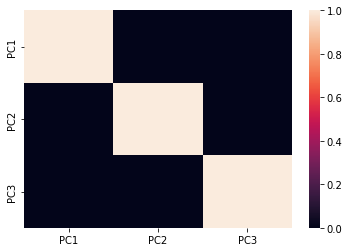

In [57]:
sns.heatmap(data_pca.corr())

In [58]:
data_pca.to_csv('data/pcagenerated/xtrainpca.csv', index=False)


In [59]:
sum(pca.explained_variance_ratio_)

0.9929313919323003

In [60]:
#X_train = pd.read_csv('data/ClassBalanced/xtrain.csv')
X_test = pd.read_csv('data/xtest.csv')
X_test_filters = X_test.loc[:, X_test.columns != "redshift"]
scaler = StandardScaler()
scaled_data2 = pd.DataFrame(scaler.fit_transform(X_test_filters))
pca = PCA(n_components = 3)
pca.fit(scaled_data2)
data_pca = pca.transform(scaled_data2)
data_pca = pd.DataFrame(data_pca,columns=['PC1','PC2','PC3'])
data_pca.head()

,PC1,PC2,PC3
0,-1.325270,-0.550050,-0.195021
1,-0.055047,0.132068,0.083537
2,0.362241,-0.855945,0.019186
3,0.105098,-1.197741,0.275610
4,-0.056046,-0.521745,-0.102929


In [61]:
data_pca.to_csv('data/pcagenerated/xtestpca.csv', index=False)
sum(pca.explained_variance_ratio_)

0.9925477143243071